In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

In [2]:
df = pd.read_csv("LVMUY.csv")

In [3]:
df_grouped = df.groupby(['Year', 'Week_Number'])['Return'].agg([np.mean,np.std])
df_grouped.reset_index(['Year', 'Week_Number'], inplace=True)
df_grouped.rename(columns={'mean': 'mean_Return_μ','std':'std_Return_σ'}, inplace=True)

In [4]:
def getWeeklyDifferences(df):
    lastClosePrice = np.asarray(df.groupby(["Year", "Week_Number"]).last()["Close"])
    firstOpenPrice = np.asarray(df.groupby(["Year", "Week_Number"]).first()["Open"])
    return lastClosePrice - firstOpenPrice
def getLabels(df):
    weeklyDifferences = getWeeklyDifferences(df)
    return [1 if x >= 0 else 0 for x in weeklyDifferences]

In [5]:
df_grouped['Weekly_Label']=getLabels(df)
df_grouped['WeeklyDif'] = getWeeklyDifferences(df)
df_grouped.dropna(inplace=True)
df_grouped

,Year,Week_Number,mean_Return_μ,std_Return_σ,Weekly_Label,WeeklyDif
0,2014,0,-0.005560,0.007863,0,-0.32
1,2014,1,-0.006661,0.017478,0,-0.82
2,2014,2,-0.000721,0.009552,0,-0.12
3,2014,3,-0.002957,0.018201,0,-1.31
4,2014,4,0.010164,0.022332,1,1.80
...,...,...,...,...,...,...
311,2019,48,-0.000431,0.012718,0,-0.54
312,2019,49,0.002777,0.006309,1,1.36
313,2019,50,0.002657,0.012763,0,-0.49
314,2019,51,0.006299,0.005811,1,1.81


In [6]:
df_2017 = df_grouped[df_grouped.Year == 2017]
df_2018 = df_grouped[df_grouped.Year == 2018]

In [9]:
X_train, y_train = df_2017[['mean_Return_μ', 'std_Return_σ']], df_2017['Weekly_Label']
X_test, y_test = df_2018[['mean_Return_μ', 'std_Return_σ']], df_2018['Weekly_Label']

## Random Forest

In [10]:
def RFModelErrorRate(train_data, test_data,feature,prediction, d, N):
    """
    Build a randomforest model. Use train_data to train the classifier and predict the test_data.
    N - number of (sub)trees to use 
    d - max depth of each subtree
    """
    #train the random forest model by the stock data in year 1
    X_train, y_train = train_data[feature].values , train_data[prediction].values
    sc = StandardScaler()
    X_train = sc.fit_transform(X_train)
    rfc=RandomForestClassifier( max_depth=d,n_estimators= N ,random_state=1998)
    rfc.fit(X_train,y_train)
    
    #predict the label in year 2
    X_test, y_test = test_data[feature].values, test_data[prediction].values
    X_test = sc.transform(X_test)
    pred_Y = rfc.predict(X_test)
    ACC = accuracy_score(y_test,pred_Y)
    error_rate = 1 - ACC
    return 1-ACC

In [21]:
features = ['mean_Return_μ', 'std_Return_σ']
label = ['Weekly_Label']
RFModelErrorRate(df_2017, df_2018,features, label, 3,3)

D:\TEMP/ipykernel_26184/781995735.py:12: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rfc.fit(X_train,y_train)


0.15384615384615385

In [23]:
errors = {'-'.join([str(d), str(n)]): RFModelErrorRate(df_2017,df_2018, features, label, d, n)
              for d in range(1, 6) for n in range(1, 11)}

D:\TEMP/ipykernel_26184/781995735.py:12: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rfc.fit(X_train,y_train)
D:\TEMP/ipykernel_26184/781995735.py:12: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rfc.fit(X_train,y_train)
D:\TEMP/ipykernel_26184/781995735.py:12: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rfc.fit(X_train,y_train)
D:\TEMP/ipykernel_26184/781995735.py:12: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rfc.fit(X_train,y_train)
D:\TEMP/ipykernel_26184/781995735.py:12: DataConversionWarning: A column-vector y was passed when a 1d array

D:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


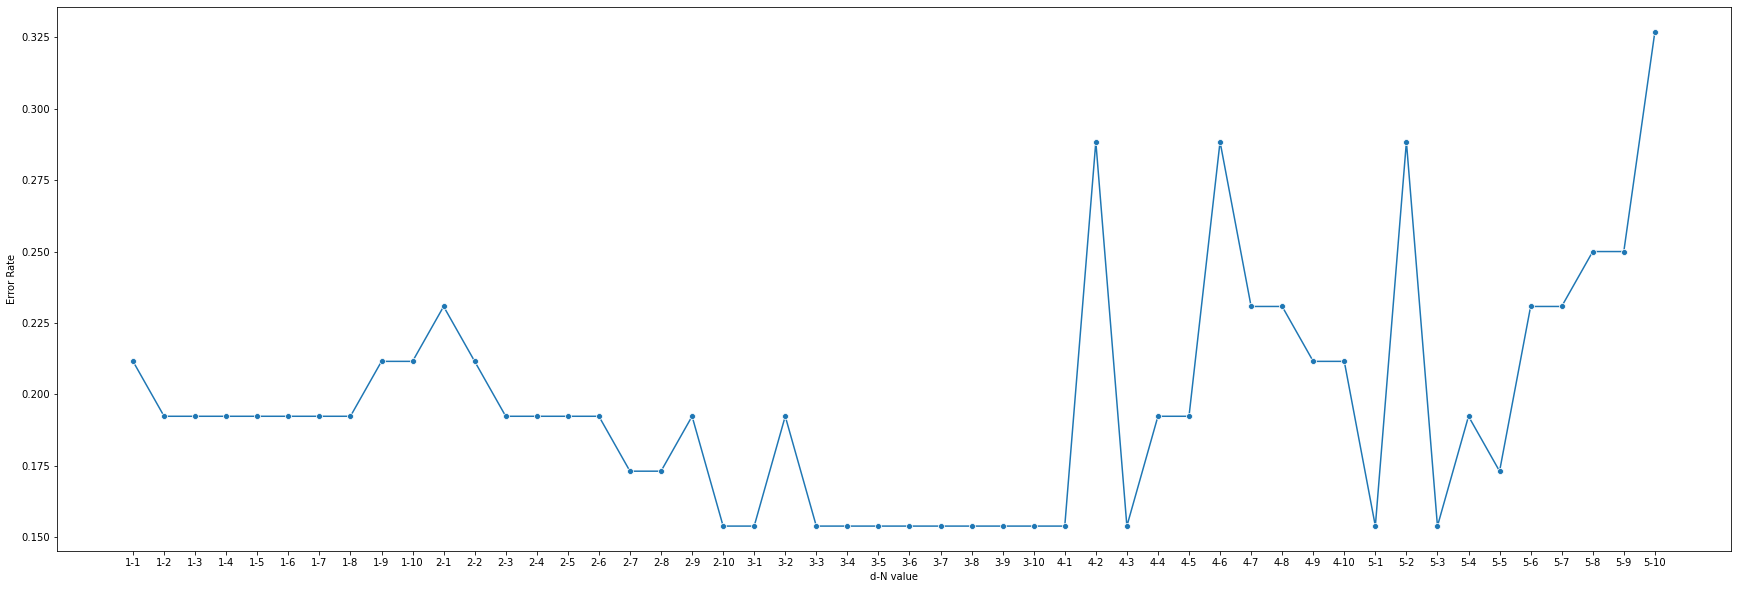

In [14]:
plt.figure(figsize = (30,10))
sns.lineplot(list(errors.keys()), list(errors.values()), marker='o')
plt.xlabel('d-N value')
plt.ylabel('Error Rate')
plt.show()

#### Based on the error rate plot, we can choose d=3 and N=3 for the best model

In [16]:
#calculate the confusion matrix for the best model
rf = RandomForestClassifier(max_depth=3, n_estimators=3).fit(X_train, y_train)
prediction_rf = rf.predict(X_test)
confusion_matrix(y_test, prediction_rf)

array([[17,  5],
       [ 7, 23]], dtype=int64)

In [17]:
#TPR and TNR
from sklearn.metrics import recall_score
TPR = recall_score(y_test, prediction_rf)
tn, fp, fn, tp = confusion_matrix(y_test, prediction_rf).ravel()
TNR = tn / (tn + fp)

In [18]:
TPR

0.7666666666666667

In [19]:
TNR

0.7727272727272727

## RF trading strategy

In [25]:
test = df[df.Year == 2017]
weeklyDifferences = getWeeklyDifferences(test)
weeklyOpens = test.groupby(["Year", "Week_Number"]).first().Open
weeklyCloses = test.groupby(["Year", "Week_Number"]).last().Close

percentGains = np.asarray((weeklyCloses - weeklyOpens) / weeklyOpens)
dailyPercentGains = np.asarray((test.Close - test.Open)/test.Open)

initialInvestment = 100
buyAndHold = [initialInvestment]

In [26]:
#Buy and Hold
#PercentGains are weekly so this will take of the weeks
labels = list(range(len(percentGains) + 1))

for pg in percentGains:
    buyAndHold.append(buyAndHold[-1] * (1 + pg)) if pg >= 0 else buyAndHold.append(buyAndHold[-1] / (1 - pg) )    

In [27]:
#random forest portfolio
rfPortfolio = [initialInvestment]

for index  in range(len(prediction_rf)):
    pg = percentGains[index]
    if prediction_rf[index] == 1:
        rfPortfolio.append(rfPortfolio[-1] * (1 + pg)) if pg >= 0 else rfPortfolio.append(buyAndHold[-1] / (1 - pg) )  
    else:
        rfPortfolio.append(rfPortfolio[-1])

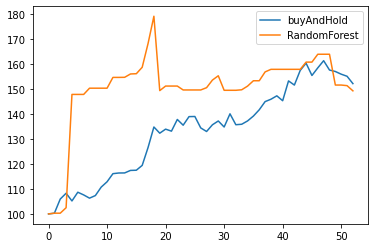

In [28]:
plt.plot(labels, buyAndHold)
plt.plot(labels, rfPortfolio, label = "RandomForest")
plt.legend(["buyAndHold", "RandomForest"])

buy-and-hold strategy earn more at the end of the year. But before that, randomForest classifier model performed better.

## Desision Tree

In [29]:
#tree model
from sklearn import tree
clf = tree.DecisionTreeClassifier(criterion = 'entropy', max_features = 2).fit(X_train, y_train)
prediction_yr2 = clf.predict(X_test)

In [30]:
#accuracy
accuracy_score(y_test, prediction_yr2)

0.7307692307692307

In [31]:
#confusion matrix
confusion_matrix(y_test, prediction_yr2)

array([[17,  5],
       [ 9, 21]], dtype=int64)

In [32]:
#TPR and TNR
from sklearn.metrics import recall_score
TPR = recall_score(y_test, prediction_yr2)
tn, fp, fn, tp = confusion_matrix(y_test, prediction_yr2).ravel()
TNR = tn / (tn + fp)

In [34]:
TPR

0.7

In [35]:
TNR

0.7727272727272727

In [36]:
#Decision tree portfolio
treePortfolio = [initialInvestment]

for index  in range(len(prediction_yr2)):
    pg = percentGains[index]
    if prediction_yr2[index] == 1:
        treePortfolio.append(treePortfolio[-1] * (1 + pg)) if pg >= 0 else treePortfolio.append(buyAndHold[-1] / (1 - pg) )  
    else:
        treePortfolio.append(treePortfolio[-1])

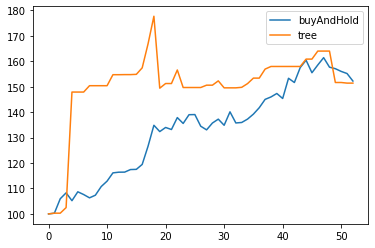

In [37]:
plt.plot(labels, buyAndHold)
plt.plot(labels, treePortfolio, label = "tree")
plt.legend(["buyAndHold", "tree"])

the tree model performs better than buy-and-hold